In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_resource_variables()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from imgaug import augmenters as iaa
from keras.utils import plot_model
import numpy as np

# channels last, no. of channels = 3
img_width, img_height = 256, 256
input_shape = (img_width, img_height, 3)

train_data_dir = "C:/Users/91890/Downloads/Dataset (1)/Dataset/Train"
validation_data_dir = "C:/Users/91890/Downloads/Dataset (1)/Dataset/Validation"
test_data_dir = "C:/Users/91890/Downloads/Dataset (1)/Dataset/Test"
nb_train_samples = 280
nb_validation_samples = 80
n_test_samples = 40
epochs = 100

In [3]:
def get_steps(n_samples, batch_size):
    if n_samples <= batch_size:
        return n_samples
    elif np.remainder(n_samples, batch_size) == 0:
        return n_samples//batch_size
    else:
        return n_samples//batch_size + 1

In [4]:
input = Input(shape=input_shape)

# Block 1
block1 = Conv2D(16, (3,3), name='conv_11', activation='relu')(input)
block1 = MaxPooling2D(pool_size=(2, 2))(block1)
block1 = BatchNormalization(name='norm_1')(block1)

# Block 2
block2 = Conv2D(32, (3,3), name='conv_21', activation='relu')(block1)
block2 = MaxPooling2D(pool_size=(2, 2))(block2)
block2 = BatchNormalization(name='norm_2')(block2)

# Block 3
block3 = Conv2D(64, (3,3), name='conv_31', activation='relu')(block2)
block3 = MaxPooling2D(pool_size=(2, 2))(block3)
block3 = BatchNormalization(name='norm_3')(block3)

# Block 4
block4 = Conv2D(128, (3,3), name='conv_41', activation='relu')(block3)
block4 = MaxPooling2D(pool_size=(2, 2))(block4)
block4 = BatchNormalization(name='norm_4')(block4)

# Output block
output = Flatten()(block4)
output = Dense(2, activation='softmax')(output)

model = Model(inputs=[input], outputs=[output])
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False), metrics=["accuracy"])

plot_model(model, to_file = "model.png", show_shapes = True)
model.summary()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv_11 (Conv2D)            (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 norm_1 (BatchNormalization  (None, 127, 127, 16)      64        
 )                                                               
                                                                 
 conv_21 (Conv2D)            (None, 125, 125

C:\Users\91890\anaconda3\lib\site-packages\keras\src\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                 
 conv_31 (Conv2D)            (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 norm_3 (BatchNormalization  (None, 30, 30, 64)        256       
 )                                                               
                                                                 
 conv_41 (Conv2D)            (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 norm_4 (BatchNormalization  (None, 14, 14, 128)       512       
 )        

In [5]:

# Augmentationb              
sometimes = lambda aug: iaa.Sometimes(0.6, aug)
seq = iaa.Sequential([
                      iaa.GaussianBlur(sigma=(0 , 1.0)),
                      iaa.Sharpen(alpha=1, lightness=0),
                      iaa.CoarseDropout(p=0.1, size_percent=0.15),
                              sometimes(iaa.Affine(
                                                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                                    rotate=(-30, 30),
                                                    shear=(-16, 16)))
                    ])

Found 280 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


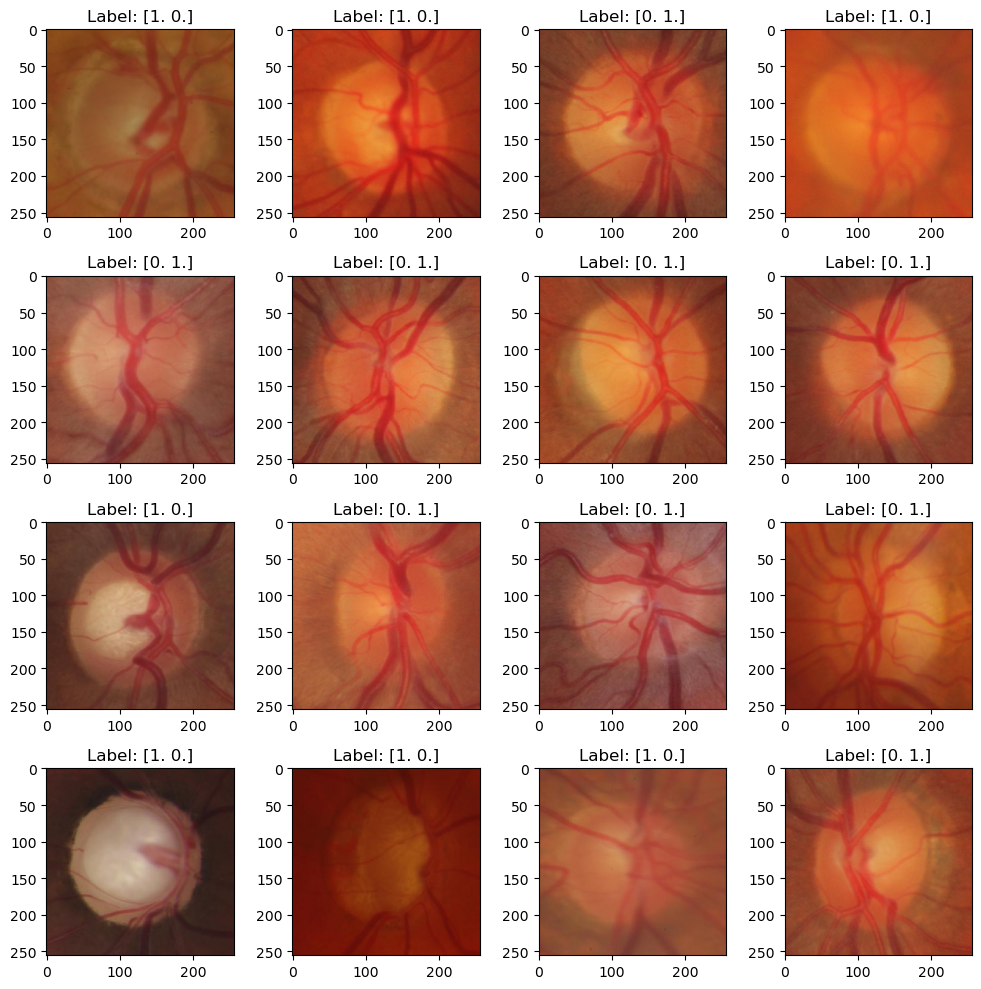

In [6]:
# Data generators

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # preprocessing_function=seq.augment_image,
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True) 

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode="categorical")

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    class_mode="categorical")

# Display generated images
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))

for i, ax in enumerate(axes.flat):
    # Show augmented image
    ax.imshow(x_batch[i])
    # Show corresponding label
    ax.set_title(f"Label: {y_batch[i]}")

plt.tight_layout()
plt.show()

In [7]:
# Callbacks
checkpoint = ModelCheckpoint("C:/Users/91890/Desktop/f1.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=0, mode='auto', cooldown=0, min_lr=0)
     

C:\Users\91890\AppData\Local\Temp\ipykernel_5600\859205832.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.7754 - accuracy: 0.6411
Epoch 1: accuracy improved from -inf to 0.64113, saving model to C:/Users/91890/Desktop\f1.h5


C:\Users\91890\anaconda3\lib\site-packages\keras\src\engine\training.py:2992: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 63s 8s/step - loss: 0.7754 - accuracy: 0.6411 - val_loss: 0.6894 - val_accuracy: 0.5156 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.4945 - accuracy: 0.8065
Epoch 2: accuracy improved from 0.64113 to 0.80645, saving model to C:/Users/91890/Desktop\f1.h5
8/8 [==============================] - 36s 5s/step - loss: 0.4945 - accuracy: 0.8065 - val_loss: 0.6915 - val_accuracy: 0.4688 - lr: 1.0000e-04
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8266
Epoch 3: accuracy improved from 0.80645 to 0.82661, saving model to C:/Users/91890/Desktop\f1.h5
8/8 [==============================] - 25s 3s/step - loss: 0.4138 - accuracy: 0.8266 - val_loss: 0.6917 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.8508
Epoch 4: accuracy improved from 0.82661 to 0.85081, saving model to C:/Users/91890/Desktop\f1.h

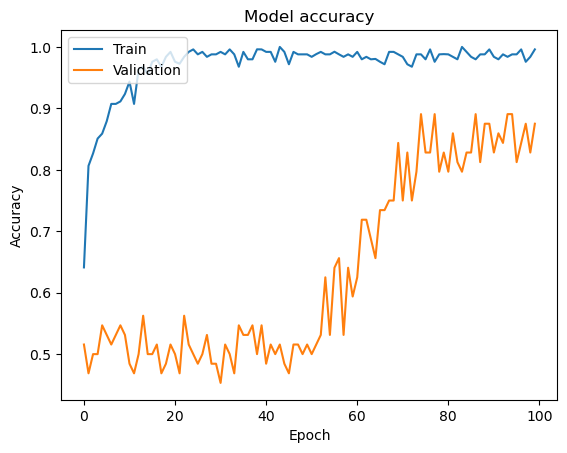

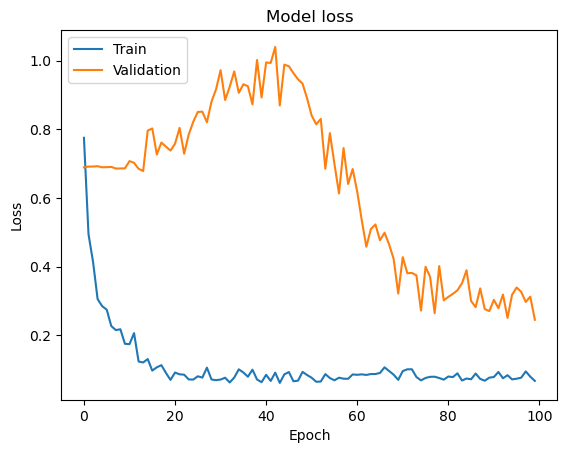

3/3 [==============================] - 37s 1s/step


NameError: name 'precision_score' is not defined

In [8]:
import matplotlib.pyplot as plt
from keras.callbacks import History

batch_size = 32

history = History()

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[checkpoint, reduce_lr,  history]
)

# Plotting accuracy and loss graphs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Calculating and displaying precision, selectivity, accuracy, sensitivity, tp, tn, fp, fn
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = y_pred.argmax(axis=1)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
tp, fp, fn, tn = conf_matrix.ravel()

print(f"Precision: {precision}")
print(f"Selectivity: {tn / (tn + fp)}")
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {tp / (tp + fn)}")
print(f"TP: {tp}")
print(f"FP: {fp}")
print(f"FN: {fn}")
print(f"TN: {tn}")

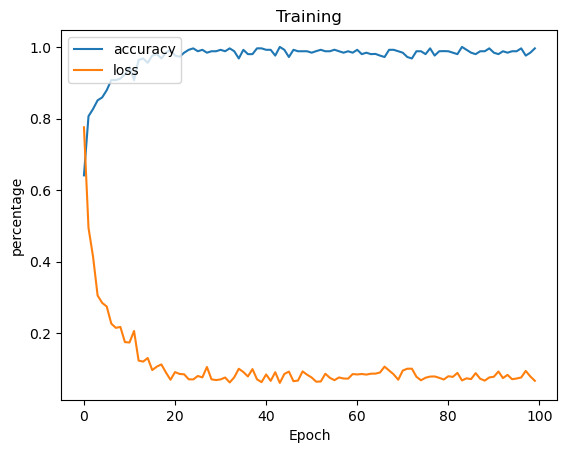

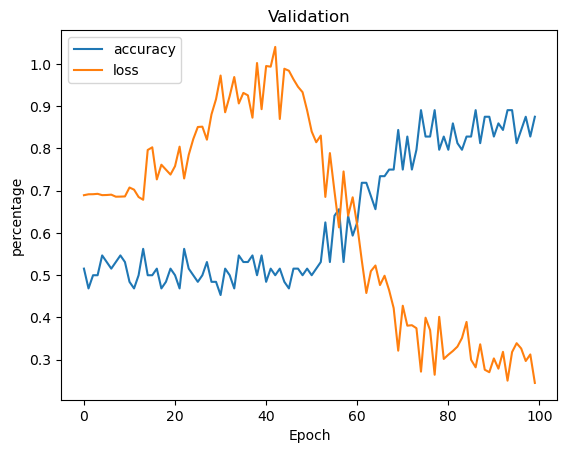

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Training')
plt.ylabel('percentage')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Validation')
plt.ylabel('percentage')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [21]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = load_model('C:/Users/91890/Desktop/f1.h5')

# Load and preprocess the image to be predicted
image = load_img('C:/Users/91890/Downloads/Dataset (1)/Dataset/Test/normal/Im182.jpg', target_size=(256, 256))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array /= 255.

# Predict the class of the image
prediction = model.predict(image_array)
predicted_class = np.argmax(prediction)

print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 2s 2s/step
Predicted class: 0
